# 1. Import Libraries

In [2]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment

from tqdm.notebook import tqdm
tqdm.pandas()


# 2. Load Data

In [4]:
data = pd.read_csv('../Dataset/bigmartsales.csv')
data

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,6.800000,0.037490,48.6034,2004,291.6204,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
1,15.600000,0.172597,114.8518,1997,2163.1842,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0
2,12.911575,0.054721,107.8254,1985,2387.5588,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,11.800000,0.098312,81.4618,1998,161.1236,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,17.850000,0.046600,125.1388,2004,1981.4208,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,12.911575,0.150123,154.5314,1985,1396.1826,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1701,12.150000,0.015524,212.0928,2009,2735.1064,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1702,12.911575,0.024032,124.9730,1985,2463.4600,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1703,10.195000,0.126383,112.1886,1997,667.1316,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0


# 3. Initial Analysis

### 3.1. Metadata

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      1705 non-null   float64
 1   Item_Visibility                  1705 non-null   float64
 2   Item_MRP                         1705 non-null   float64
 3   Outlet_Establishment_Year        1705 non-null   int64  
 4   Item_Outlet_Sales                1705 non-null   float64
 5   Item_Fat_Content_LF              1705 non-null   int8   
 6   Item_Fat_Content_Low Fat         1705 non-null   int8   
 7   Item_Fat_Content_Regular         1705 non-null   int8   
 8   Item_Fat_Content_low fat         1705 non-null   int8   
 9   Item_Fat_Content_reg             1705 non-null   int8   
 10  Item_Type_Baking Goods           1705 non-null   int8   
 11  Item_Type_Breads                 1705 non-null   int8   
 12  Item_Type_Breakfast 

In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Item_Weight,1705.0,12.911575,4.211454,4.555,9.500000,12.911575,16.100000,21.250000
Item_Visibility,1705.0,0.065598,0.051951,0.000,0.026547,0.053398,0.092937,0.321115
Item_MRP,1705.0,142.698052,62.667925,31.490,95.009400,143.812800,186.658200,266.688400
Outlet_Establishment_Year,1705.0,1998.053372,8.240094,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,1705.0,2205.287752,1723.413422,33.290,874.861200,1796.328400,3062.014200,13086.964800
Item_Fat_Content_LF,1705.0,0.037537,0.190129,0.000,0.000000,0.000000,0.000000,1.000000
Item_Fat_Content_Low Fat,1705.0,0.594721,0.491090,0.000,0.000000,1.000000,1.000000,1.000000
Item_Fat_Content_Regular,1705.0,0.344282,0.475273,0.000,0.000000,0.000000,1.000000,1.000000
Item_Fat_Content_low fat,1705.0,0.012903,0.112890,0.000,0.000000,0.000000,0.000000,1.000000
Item_Fat_Content_reg,1705.0,0.010557,0.102234,0.000,0.000000,0.000000,0.000000,1.000000


In [7]:
print(f'Number of null data       : {data.isnull().sum().sum()}')
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of null data       : 0
Number of duplicates data : 0


### 3.2. Columns Processing

In [5]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Item_Fat_Content_LF', 'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular', 'Item_Fat_Content_low fat', 'Item_Fat_Content_reg', 'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']
Categorical Columns : []


In [6]:
def downcasting_dtypes(data):
    to_numeric = ['Item_Fat_Content_LF', 'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular', 'Item_Fat_Content_low fat', 'Item_Fat_Content_reg', 'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast', 
                'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 
                'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1',
                'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']
    
    for column in to_numeric:
        # data[column] = pd.to_numeric(data[column])
        data[column] = data[column].astype('int8')

downcasting_dtypes(data)

In [11]:
# data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())
# data[categorical_columns] = data[categorical_columns].fillna(data.value_counts().iloc[0])

In [ ]:
# def change_columns_to_numerical(data):
#     LE = LabelEncoder()
#     columns = ['Region']
#     for column in columns:
#         data[column] = LE.fit_transform(data[column].astype(str))
#         data[column] = data[column].astype(int)
#         print(f'{column} : {LE.classes_}') 
#     return data

# data = change_columns_to_numerical(data)

### 3.3. EDA

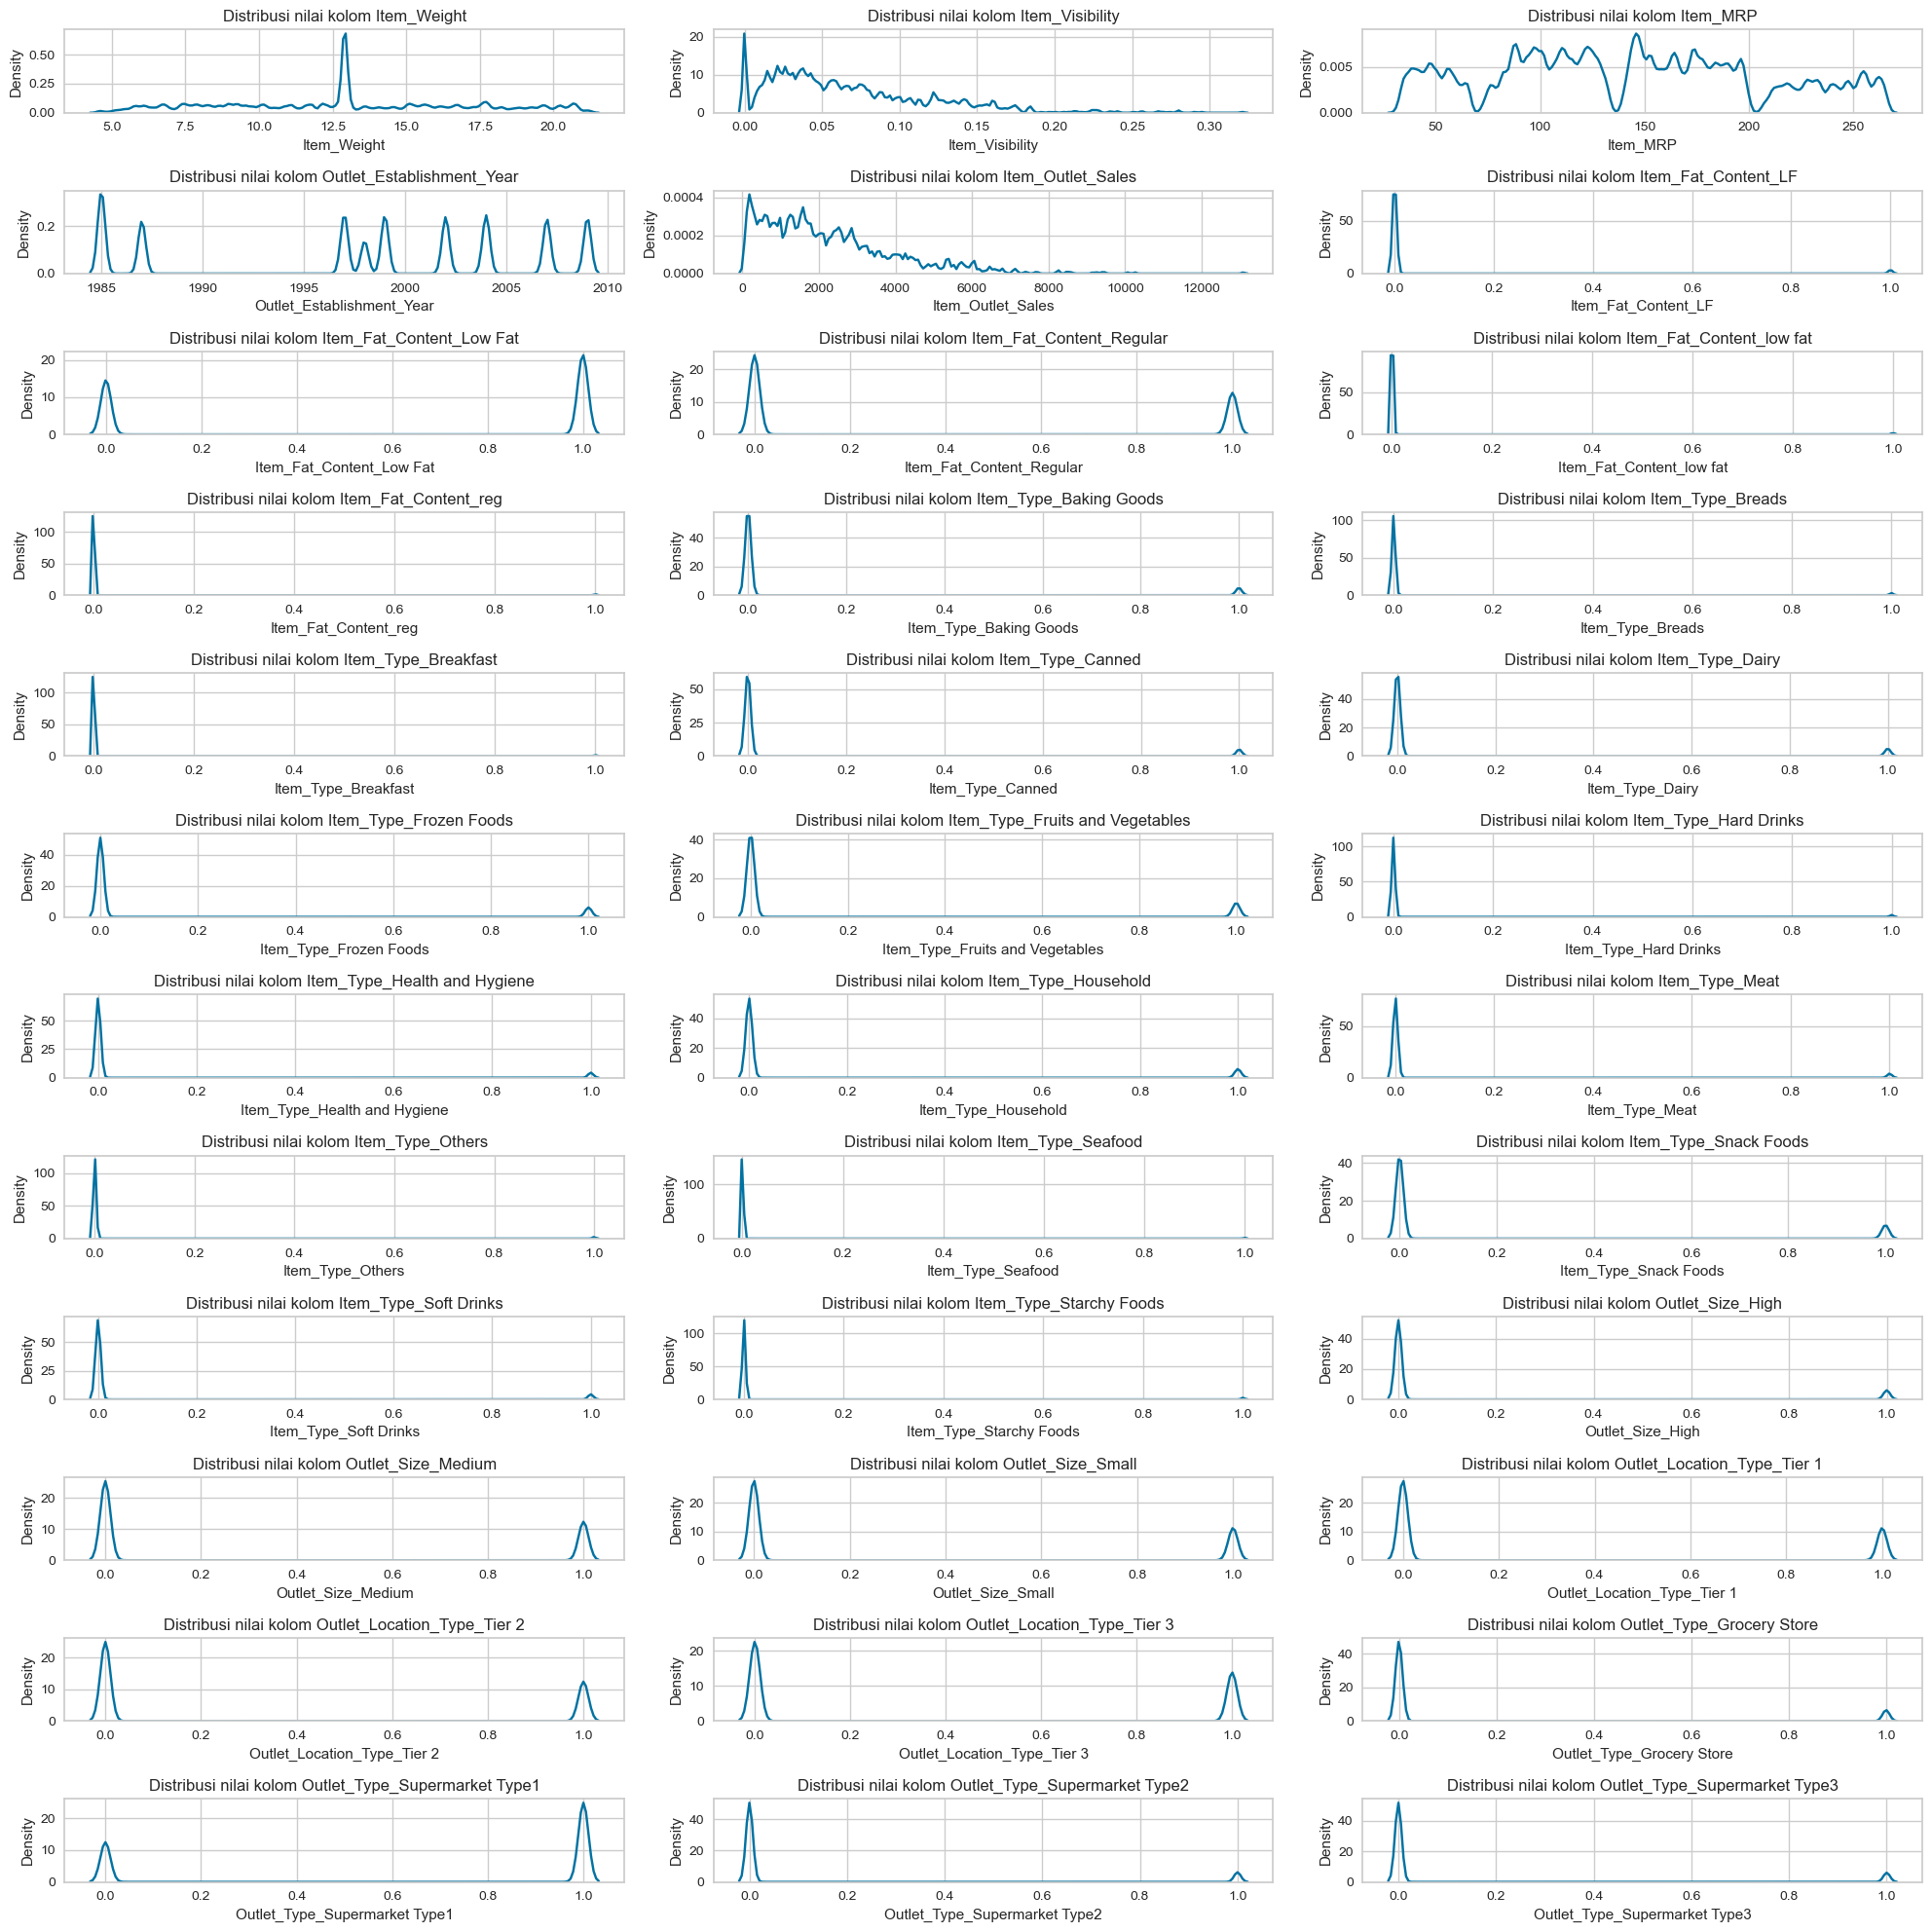

In [12]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="Region", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
sns.pairplot(data, diag_kind="kde")

In [ ]:
# plt.subplots(figsize = (20,4))
# ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
# ax.bar_label(ax.containers[0])

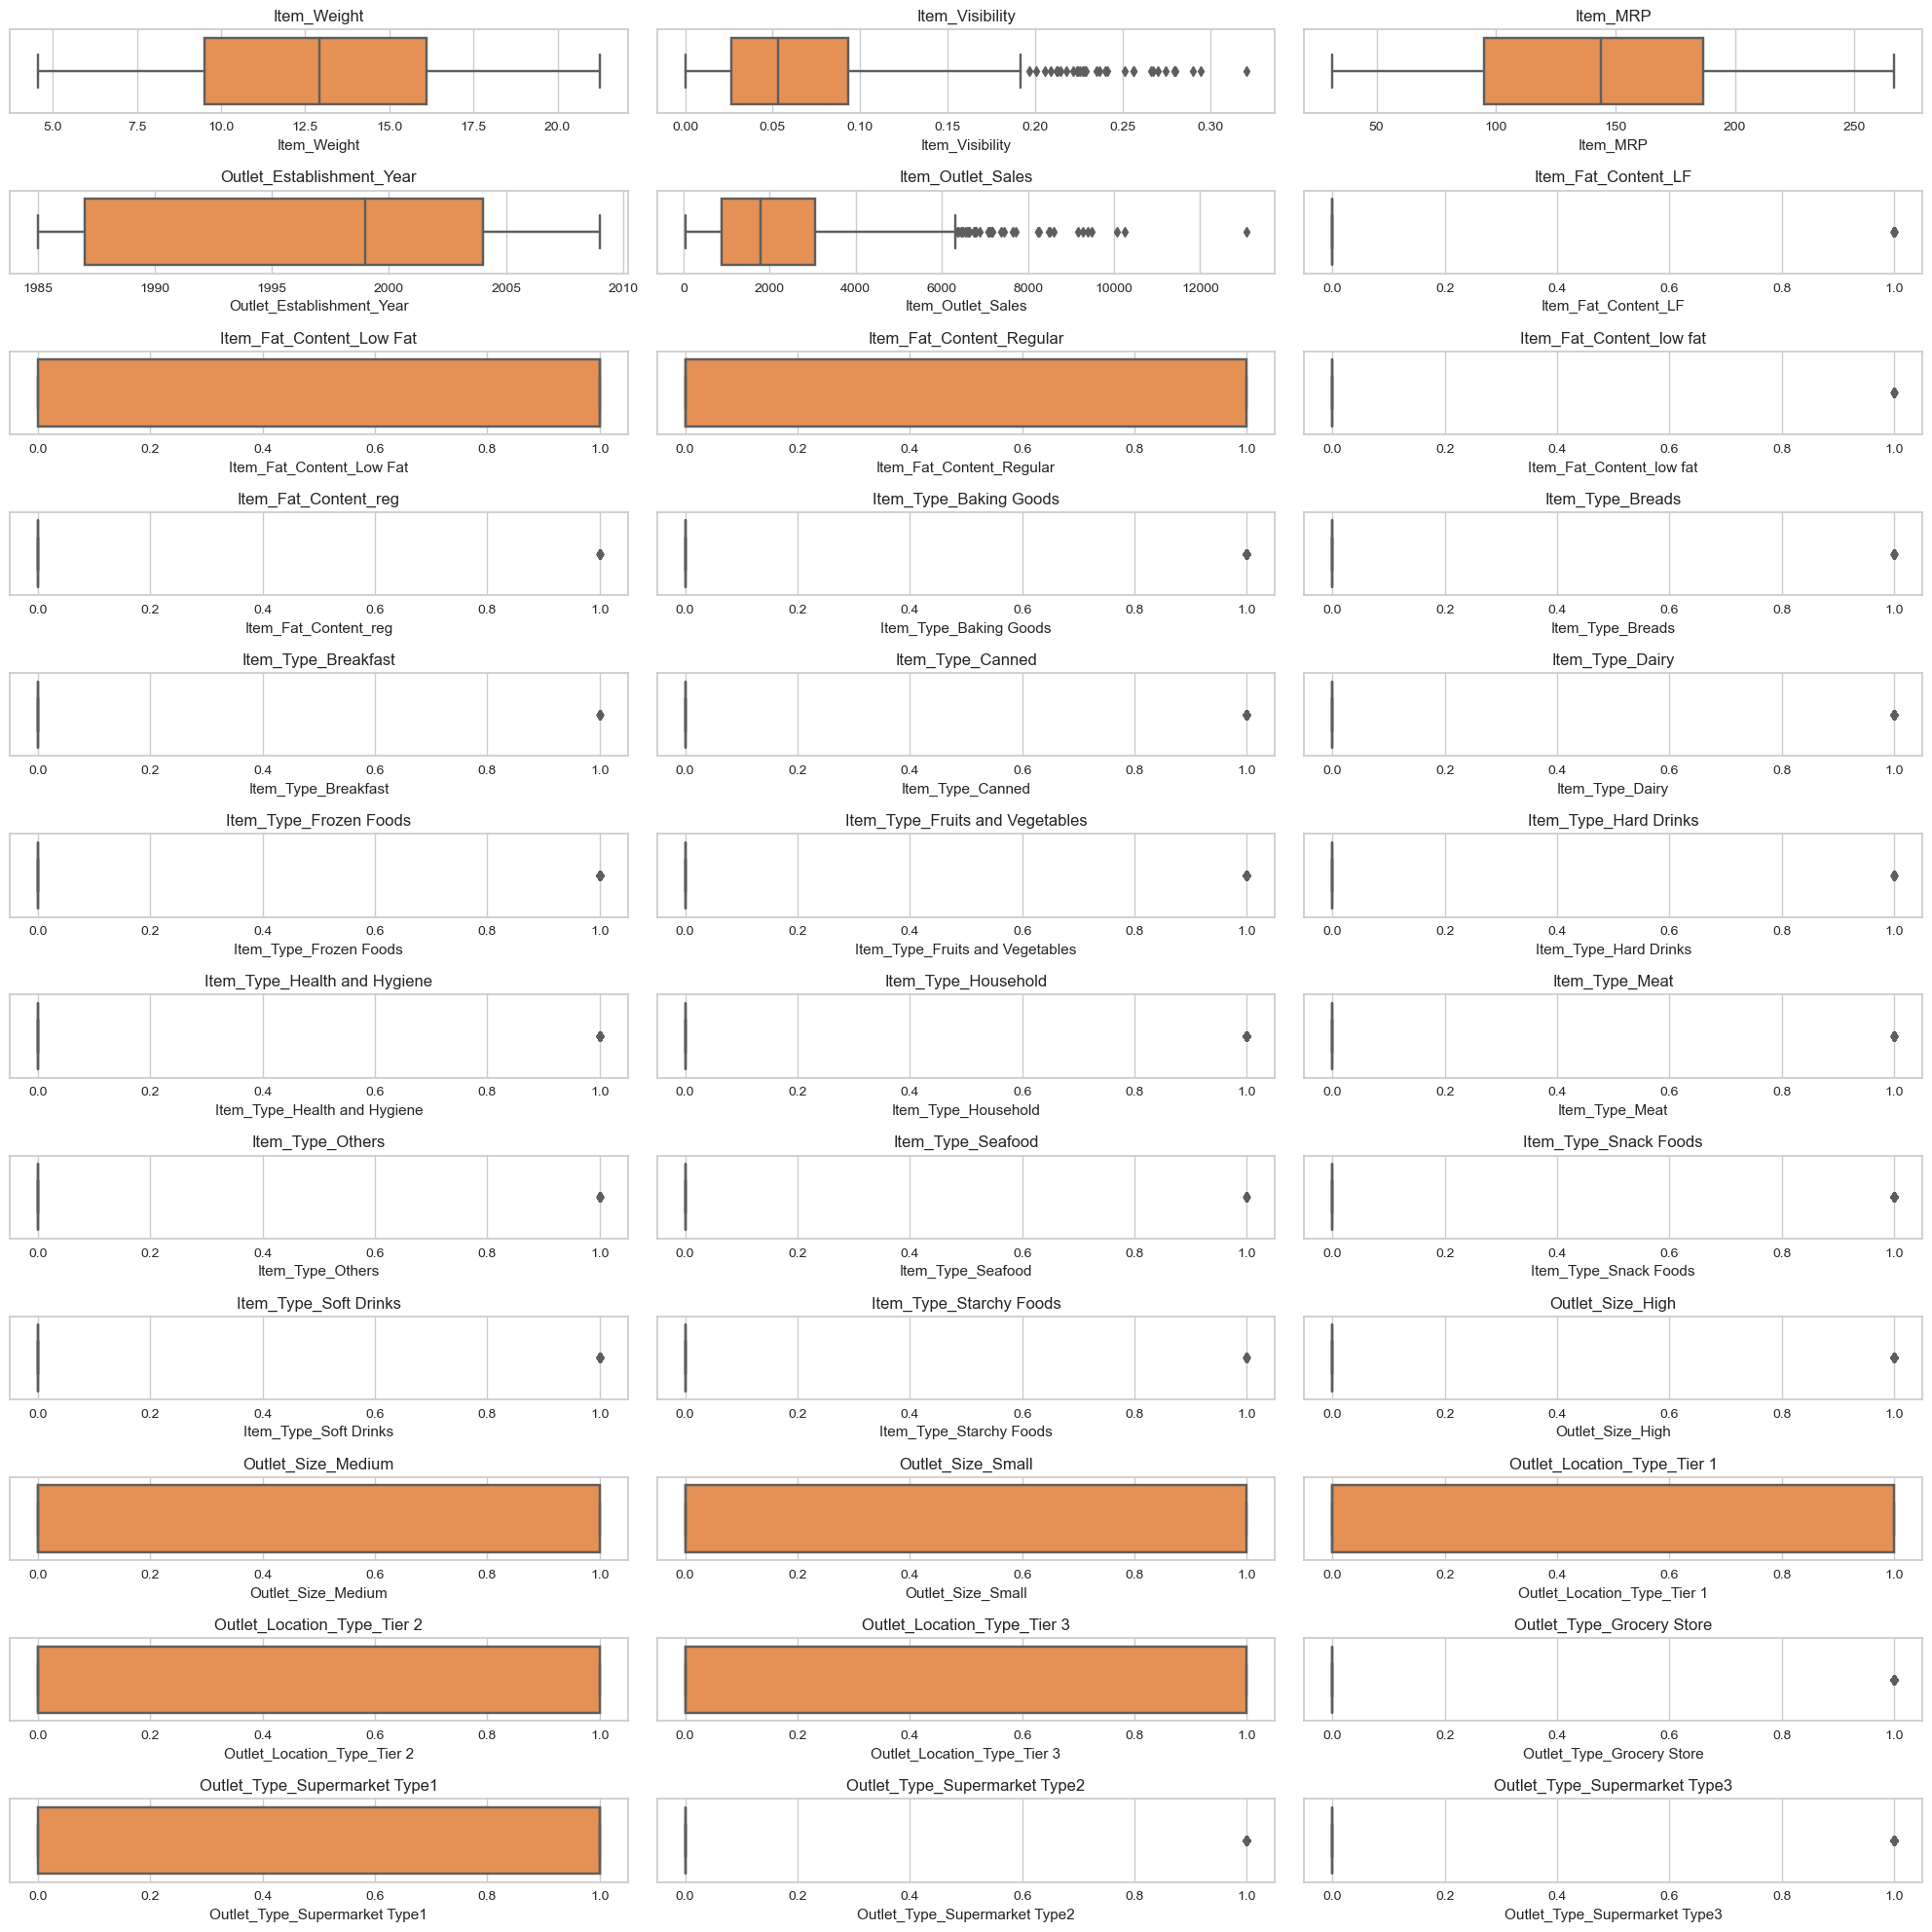

In [13]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

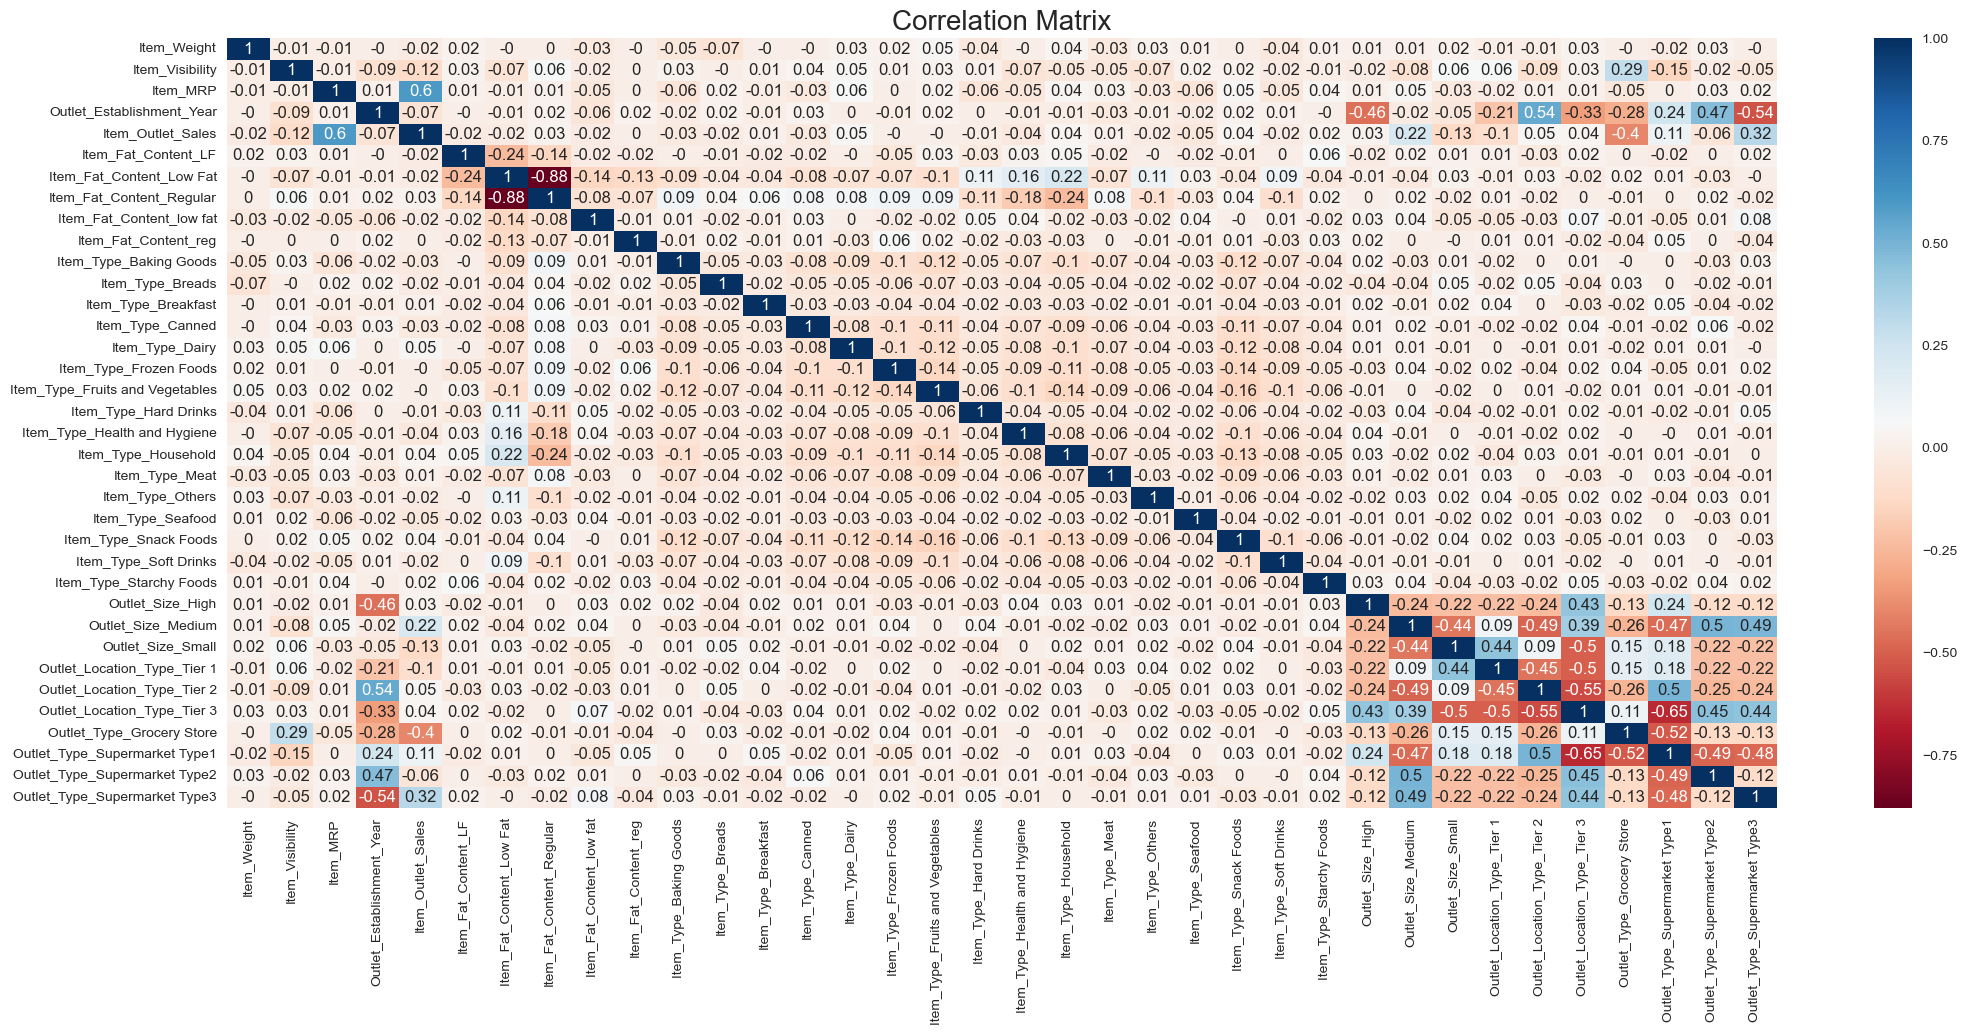

In [7]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)
plt.show()

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [8]:
X = data.drop(columns=['Item_Outlet_Sales'])
Y = data['Item_Outlet_Sales']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = RobustScaler()
# X = scaler.fit_transform(X)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1196, 35) (1196,)
(338, 35) (338,)
(171, 35) (171,)


# 5. Neural Network Algoritms

In [15]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# model.compile(loss='mae', optimizer = opt, metrics=['mae'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              36864     
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 315,777
Trainable params: 315,777
Non-trainable params: 0
_________________________________________________________________


In [18]:
num_epoch = 100
batch_size = 32

history = model.fit(X_train, y_train, verbose=2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

Epoch 1/100
38/38 - 0s - loss: 992008.2500 - mse: 991989.0000 - val_loss: 1687152.1250 - val_mse: 1687133.0000 - 339ms/epoch - 9ms/step
Epoch 2/100
38/38 - 0s - loss: 992769.9375 - mse: 992750.5625 - val_loss: 1682953.0000 - val_mse: 1682933.7500 - 119ms/epoch - 3ms/step
Epoch 3/100
38/38 - 0s - loss: 990786.8750 - mse: 990767.4375 - val_loss: 1677248.1250 - val_mse: 1677228.8750 - 121ms/epoch - 3ms/step
Epoch 4/100
38/38 - 0s - loss: 987874.5625 - mse: 987855.0625 - val_loss: 1686635.0000 - val_mse: 1686615.6250 - 111ms/epoch - 3ms/step
Epoch 5/100
38/38 - 0s - loss: 987808.1250 - mse: 987788.5000 - val_loss: 1692256.3750 - val_mse: 1692237.1250 - 114ms/epoch - 3ms/step
Epoch 6/100
38/38 - 0s - loss: 985627.6250 - mse: 985608.2500 - val_loss: 1687054.6250 - val_mse: 1687035.0000 - 118ms/epoch - 3ms/step
Epoch 7/100
38/38 - 0s - loss: 985837.0625 - mse: 985817.5000 - val_loss: 1687512.7500 - val_mse: 1687493.2500 - 113ms/epoch - 3ms/step
Epoch 8/100
38/38 - 0s - loss: 983446.5000 - mse

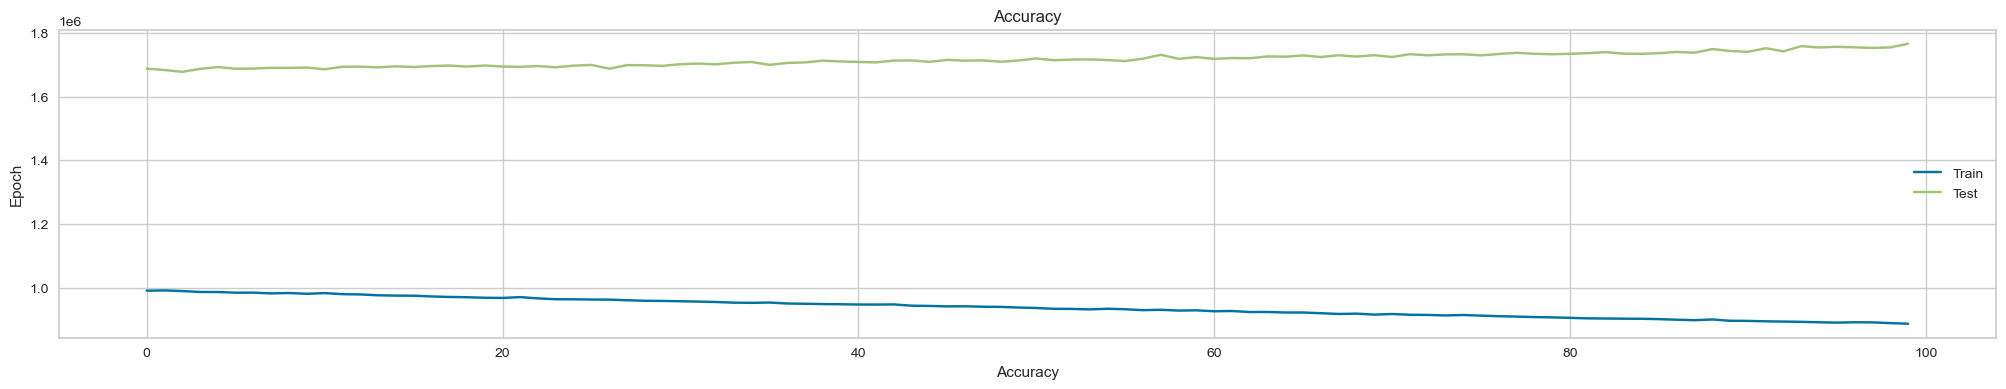

In [19]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [21]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

R Squared Error    : 0.52
Mean Squared Error : 1212024.29
Mean Absolute Error: 824.91


In [24]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


      Train Predictions    Actuals         Diff
484         2827.382080  1374.2112  1453.170880
1052        3252.872559  1480.0734  1772.799159
682         2384.767090  1573.9512   810.815890
119         5277.423828  6478.2340  1200.810172
1183        2030.769531  2745.0934   714.323869
824.9084902126741 / 278819.06969188387
3345.5662578125


In [36]:
data_x = data.drop(columns=['Item_Outlet_Sales'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = (model.predict(data_x, verbose=0)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

ValueError: X has 36 features, but ExtraTreesRegressor is expecting 35 features as input.

# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [30]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)
linear = LinearRegression()

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
], n_jobs=-1)

In [31]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                              ('XGB',
                               XGB...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42)),
                              ('linear', LinearRegression())],
                  n_jobs=-1)

In [32]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')
print("Validationg Score  :",round((model.score(X_val, y_val)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

Train Score        : 79.67 %
Test Score         : 58.39 %
Validationg Score  : 49.42 %
R Squared Error    : 0.58
Mean Squared Error : 1040751.81
Mean Absolute Error: 787.93


In [35]:
train_predictions = (model.predict(X_test)).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


      Train Predictions    Actuals         Diff
484         2800.635477  1374.2112  1426.424277
1052        2658.054975  1480.0734  1177.981575
682         2192.303220  1573.9512   618.352020
119         4664.878424  6478.2340  1813.355576
1183        2247.977857  2745.0934   497.115543
787.9257122029172 / 266318.89072458603
2957.637805307292


In [60]:
data_x = data.drop(columns=['Name', 'Overall'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = np.rint(model.predict(data_x)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

,Name,Age,Nationality,Overall,Potential,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,GKReflexes,Defending,General,Mental,Passing,Mobility,Power,Shooting,Rating,Overall Prediction
0,L. Messi,31,6,94,94,212,0,5.0,4.0,4.0,...,8.0,29,89,71,87,91,74,88,94,94
1,Cristiano Ronaldo,33,123,94,94,326,1,5.0,4.0,5.0,...,11.0,27,88,73,81,91,83,88,94,94
2,Neymar Jr,26,20,92,93,436,1,5.0,5.0,5.0,...,11.0,28,85,72,80,94,69,84,92,92
3,De Gea,27,139,91,93,375,1,4.0,3.0,1.0,...,94.0,16,26,43,39,66,54,21,92,89
4,K. De Bruyne,27,13,91,92,374,1,4.0,5.0,4.0,...,13.0,59,79,81,92,81,76,85,92,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,46,47,65,165,1,1.0,2.0,2.0,...,9.0,45,39,46,43,55,54,37,56,47
18203,N. Christoffersson,19,144,47,63,588,1,1.0,2.0,2.0,...,12.0,19,41,37,30,40,52,39,55,47
18204,B. Worman,16,46,47,67,122,1,1.0,3.0,2.0,...,13.0,19,43,36,30,59,51,42,57,47
18205,D. Walker-Rice,17,46,47,66,587,1,1.0,3.0,2.0,...,9.0,24,44,38,39,48,50,45,56,48


### 6.2. Pycarets

In [37]:
s = RegressionExperiment()
s.setup(data, target = 'Item_Outlet_Sales', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Item_Outlet_Sales
2,Target type,Regression
3,Original data shape,"(1705, 37)"
4,Transformed data shape,"(1705, 37)"
5,Transformed train set shape,"(1193, 37)"
6,Transformed test set shape,"(512, 37)"
7,Numeric features,36
8,Preprocess,True
9,Imputation type,simple


In [38]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:30:58
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


HuberRegressor()


In [ ]:
s.evaluate_model(best)

In [39]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,590.1542,797415.2204,892.9811,0.7127,0.4866,0.4199


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Overall Prediction,Item_Outlet_Sales,prediction_label
1134,12.150000,0.021757,165.018402,1999,0,1,0,0,0,0,...,1,0,0,0,1,0,0,2658,3302.367920,2684.177348
249,9.800000,0.141406,50.000801,2007,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1643,506.007996,1572.491272
1143,6.135000,0.079327,152.836594,1997,0,0,1,0,0,1,...,1,0,0,0,1,0,0,2648,2871.595459,2468.206772
809,12.911574,0.124300,73.469597,1985,0,1,0,0,0,0,...,1,0,0,1,0,0,0,313,298.278412,381.094023
657,6.920000,0.038447,63.585201,2004,0,1,0,0,0,0,...,0,1,0,0,1,0,0,883,751.022400,950.244089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,17.200001,0.025162,145.941803,2004,0,0,1,0,0,0,...,0,1,0,0,1,0,0,2694,1765.701660,2689.931096
1688,9.800000,0.026895,128.401993,2002,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1637,2403.538086,1719.376834
1612,16.000000,0.173463,157.697205,2009,0,0,1,0,0,0,...,0,0,1,0,0,1,0,2359,2960.146729,2184.149560
954,9.800000,0.013830,45.306000,1987,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1388,1304.968018,1318.843237
